In [2]:
import bz2
import numpy as np
import pandas as pd
from GeoBases import GeoBase
import multiprocessing as multi
import os

**First exercise: count the number of lines in Python for each file**

In [4]:
def linesCountBz2(fileName):
    f = bz2.BZ2File(fileName, 'rb')
    nblines = 0
    for line in f:
        nblines = nblines + 1
    print fileName, 'has ', nblines, 'lines'

pool = multi.Pool(2)
pool.map(linesCountBz2, ['downloads/bookings.csv.bz2', 'downloads/searches.csv.bz2'])
pool.close()
pool.join()
#linesCountBz2('downloads/bookings.csv.bz2')
#linesCountBz2('downloads/searches.csv.bz2')


downloads/bookings.csv.bz2 has  10000011 lines
downloads/searches.csv.bz2 has  20390199 lines


**Second exercise: top 10 arrival airports in the world in 2013 (using the bookings file)**

Arrival airport is the column *arr_port*. It is the IATA code for the airport

To get the total number of passengers for an airport, you can sum the column pax, grouping by arr_port. Note that there is negative pax. That corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the canceled bookings).

Print the top 10 arrival airports in the standard output, including the number of passengers.

Bonus point: Get the name of the city or airport corresponding to that airport (programatically, we suggest to have a look at GeoBases in Github)

Bonus point: Solve this problem using pandas (instead of any other approach) 

In [6]:
def top10Airports(fileName):
    fields = ['arr_port', 'pax']
    # get a textreader
    tf = pd.read_csv(fileName, chunksize=1000, sep='\s*\^', engine='python', iterator=True, usecols=fields)
    #make a DataFrame
    df = pd.concat(tf, ignore_index=True)
    df = df.groupby('arr_port').sum()
    df.sort_values('pax',inplace=True, ascending=False)
    geo_o = GeoBase(data='ori_por', verbose=False)
    df['Airport name'] = df.index.map(lambda iata : geo_o.get(iata, 'name', default='unknown'))
    print df.head(10)
    
    
top10Airports('downloads/bookings.csv.bz2')


              pax                          Airport name
arr_port                                               
LHR       88809.0               London Heathrow Airport
MCO       70930.0         Orlando International Airport
LAX       70530.0     Los Angeles International Airport
LAS       69630.0       Mc Carran International Airport
JFK       66270.0  John F Kennedy International Airport
CDG       64490.0             Paris - Charles-de-Gaulle
BKK       59460.0                          Suvarnabhumi
MIA       58150.0           Miami International Airport
SFO       58000.0   San Francisco International Airport
DXB       55590.0           Dubai International Airport


**Third exercise: plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona**

For the arriving airport, you can use the Destination column in the searches file. Plot a curve for Málaga, another one for Madrid, and another one for Barcelona, in the same figure. Bonus point: Solving this problem using pandas (instead of any other approach)



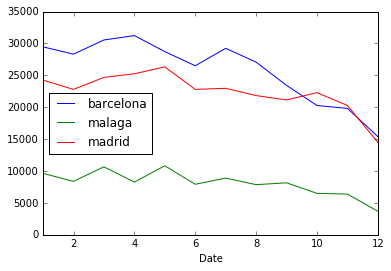

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as multi
%matplotlib inline

def plotMonthlySearchesForAirports(airports_name):
    fields = ['Date', 'Destination']    
    tf = pd.read_csv('downloads/searches.csv.bz2', chunksize=1000, sep='\s*\^', engine='python', iterator=True, usecols=fields)
    #make a DataFrame
    df = pd.concat(tf, ignore_index=True)
    #set the date
    # a first attempt was 
    #  dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]
    #  tf = pd.read_csv(fileName, parse_dates='Date', date_parser=dateparse, chunksize=1000, sep='\s*\^', engine='python', iterator=True, usecols=fields)
    #  but I got an error for a date, so I switched to the following method
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m-%d')

    geo_a = GeoBase(data='airports', verbose=False)
    for airport_name in airports_name:
        airport_iata = geo_a.fuzzyFind(airport_name, 'name')[0][1]
        airport_searches = df[df['Destination']==airport_iata]
        airport_searches = airport_searches.groupby(airport_searches['Date'].map(lambda row: row.month)).size()
        airport_searches.name = airport_name
        airport_searches.plot(legend=True)
        

plt.figure()
airports_name = ['barcelona', 'malaga', 'madrid'] 
plotMonthlySearchesForAirports(airports_name)

**Bonus exercise: match searches with bookings**

For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match. For the bookings file, origin and destination are the columns dep_port and arr_port, respectively. Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise. 

In [ ]:
def checkIfInList(value, list_of_idx):
    if value in list_of_idx:
        return 1
    return 0

def matchSearchesWithBookings():
    # from booking load origin destination (dep_port and arr_port)
    fields = ['dep_port','arr_port']
    # get a textreader
    tf_bookings = pd.read_csv('downloads/bookings.csv.bz2', chunksize=1000, sep='\s*\^', engine='python', iterator=True, usecols=fields)
    #make a DataFrame
    df_bookings = pd.concat(tf_bookings, ignore_index=True)

    tf_searches = pd.read_csv('downloads/searches.csv.bz2', chunksize=1000, sep='\s*\^', engine='python', iterator=True)
    #df_searches = pd.concat(tf_searches, ignore_index=True)

    for df_searches in tf_searches:
        # from searches load everything
        idx_match = pd.merge(df_searches,df_bookings, how='inner' , left_on=['Origin','Destination']  , right_on=['dep_port', 'arr_port'] ).index.tolist()
        df_searches['match'] = df_searches.index.map(lambda idx : checkIfInList(idx, idx_match))    
        if not os.path.isfile('downloads/searches_match.csv'):
            df_searches.to_csv('downloads/searches_match.csv',header ='column_names')
        else: # else it exists so append without writing the header
            df_searches.to_csv('downloads/searches_match.csv',mode = 'a',header=False)

matchSearchesWithBookings()

**Bonus exercise: write a Web Service**

Wrap the output of the second exercise in a web service that returns the data in JSON format (instead of printing to the standard output). The web service should accept a parameter n>0. For the top 10 airports, n is 10. For the X top airports, n is X.

In [3]:
from flask import Flask
import threading
import requests
import time

app = Flask('topAirports')
def flaskThread():
    app.run()

@app.route('/')
def help():
    return 'go to /topAirports/X to get X top airports'

@app.route('/topAirports/<int:nb_airports>')
def showTopAirports(nb_airports):
    # show the <nb_airports> top airports
    if nb_airports > 0:
        return df_top_airports.head(nb_airports).to_json()
    else:
        return 'Error nb_airports <= 0 , nb_airports=',nb_airports


print 'create df'
fields = ['arr_port', 'pax']
#put code here to avoid reloading dataset for each query    
# get a textreader
tf = pd.read_csv('downloads/bookings_sm.csv.bz2', chunksize=1000, sep='\s*\^', engine='python', iterator=True, usecols=fields)
#make a DataFrame
df_top_airports = pd.concat(tf, ignore_index=True)
df_top_airports = df_top_airports.groupby('arr_port').sum()
df_top_airports.sort_values('pax',inplace=True, ascending=False)
geo_o = GeoBase(data='ori_por', verbose=False)
df_top_airports['Airport name'] = df_top_airports.index.map(lambda iata : geo_o.get(iata, 'name', default='unknown'))
print 'df ok'
print 'launching thread'
th = threading.Thread(target=flaskThread(), args=())
th.daemon=True
th.start()
print 'th started'
time.sleep(5)
r = requests.get('http://127.0.0.1:5000/topAirports/3')
print r.text

create df
df ok
launching thread
th started


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /topAirports/3 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fe0ffdca910>: Failed to establish a new connection: [Errno 111] Connection refused',))